### Preprocessing - Skewness Correction - CNN with Regression

*This module is designed to correct skewness using OpenCV + DL

Approach
* FFT for Feature Detection
* CNN

Note:
For this purpose, I have used a publicly available Kaggle dataset ("Noisy and Rotated Scanned Documents"). The objective of choosing this dataset is because it has labelled data. I want to use supervised CNN for detecting angles and eventually compare the accuracy with the computer vision approach. Finally, all models will be applied to Input Data created using Course Descriptor.

### Connect to Google Drive

Google drive contains the input data created using Course Descriptor

In [1]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


### Load Data from Kaggle

In [2]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sthabile/noisy-and-rotated-scanned-documents?select=scan_doc_rotation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sachithgunawardane
Your Kaggle Key: ··········


100%|██████████| 8.31M/8.31M [00:01<00:00, 5.63MB/s]


### Import Libraries

In [3]:
# Helper libraries
import os
import numpy as np
import cv2
from PIL import Image
import json
from matplotlib import pyplot as plt
import pandas as pd
import random

from skimage.io import imread, imsave

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import load_model

from sklearn.model_selection import train_test_split

### Global Parameters

In [5]:
# Global Parameters

# Kaggle dataset parameters
root = '/content/noisy-and-rotated-scanned-documents/scan_doc_rotation'
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')
model_path = '/content/gdrive/MyDrive/OWR/dl_models'
model_name = 'skew_cnn_reg.h5'

# Course Descriptor Parameters
input_path = '/content/gdrive/MyDrive/OWR/data/input'
tmp_input_path = '/content/gdrive/MyDrive/OWR/data/tmp_input'
tmp_tilt_path = '/content/gdrive/MyDrive/OWR/data/tmp_tilt'
tmp_skewed_path = '/content/gdrive/MyDrive/OWR/data/tmp_skewed'
start_page = 39
end_page   = 130
angle_range = (-5, 5)
shear_range=(-0.2, 0.2)
csv_file_name = 'input.csv'

['scan_000.png', 'scan_001.png', 'scan_002.png', 'scan_003.png', 'scan_004.png', 'scan_005.png', 'scan_006.png', 'scan_007.png', 'scan_008.png', 'scan_009.png']
Total number of images: 600


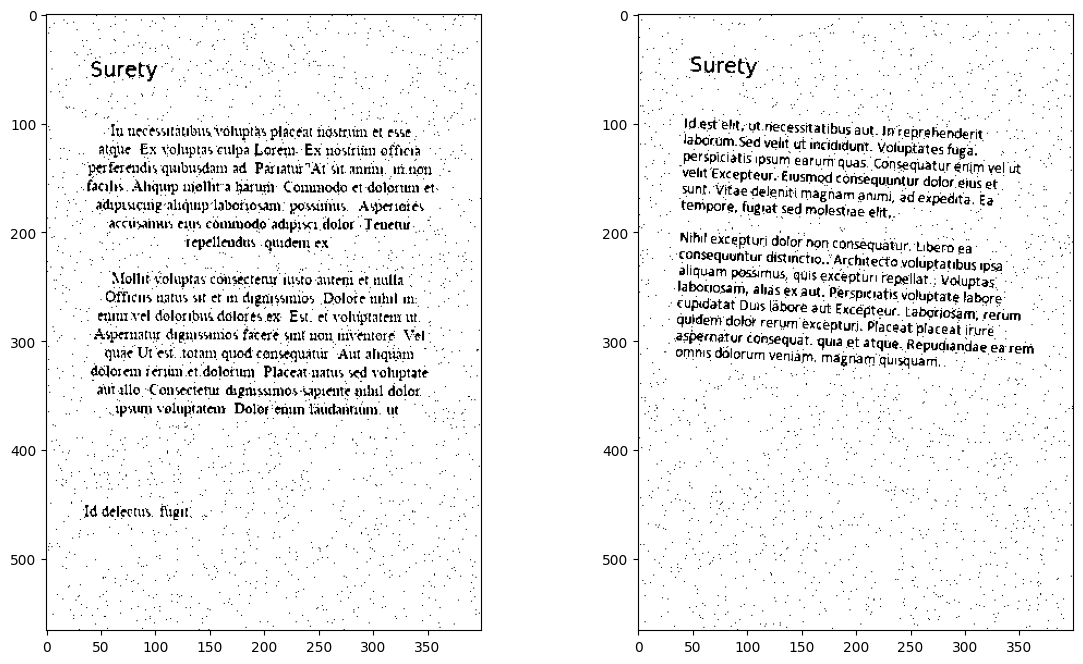

In [6]:
# Load and open images
names = [ file for file in os.listdir(image_paths) ]
names = sorted(names)
N = len(names)

print(names[:10])

# Load two images to check
images = [Image.open(image_paths+'/'+names[i]) for i in range(2)]

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(images[0], cmap = 'gray')
plt.subplot(122),plt.imshow(images[1], cmap = 'gray')

print('Total number of images: %d'%N)

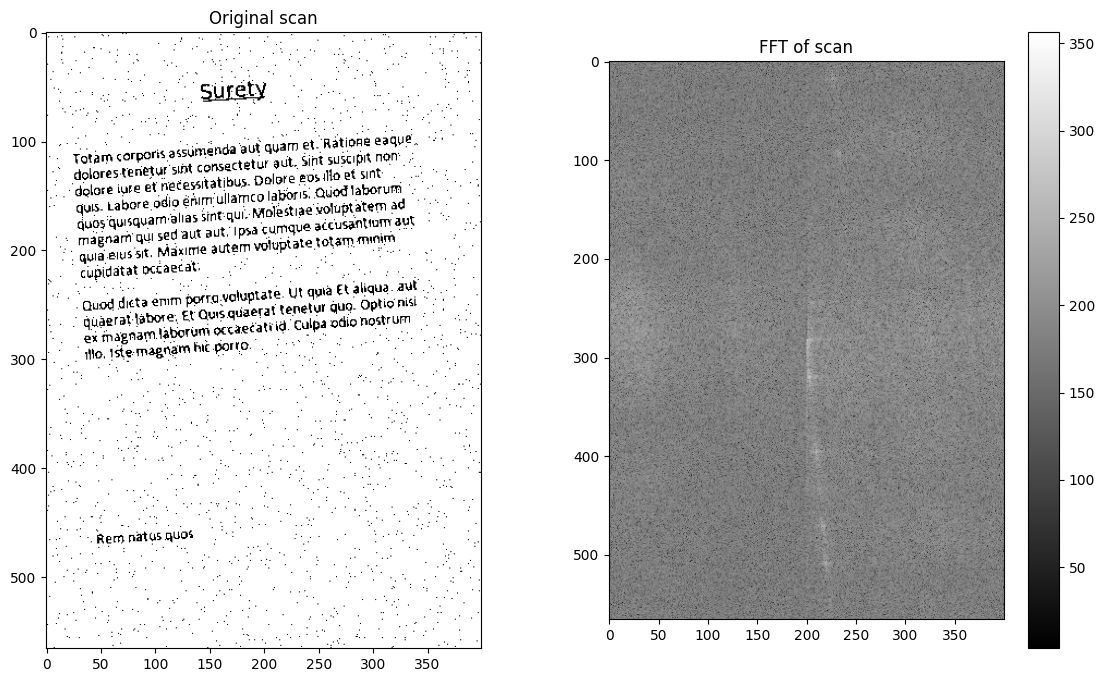

In [7]:
eg_img = image_paths +'/'+names[18]
img = cv2.imread(eg_img)
img = img[:,:,0] #zeroth component is the red from RGB channel ordering
f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0 #shift to ensure no zeroes are present in image array
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))

plt.subplot(121),plt.imshow(img, 'gray')
plt.title('Original scan')

plt.subplot(122),plt.imshow(f_img, 'gray')
plt.title('FFT of scan')
plt.colorbar()
plt.show()

<ipython-input-8-075fdb5ad525>:3: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


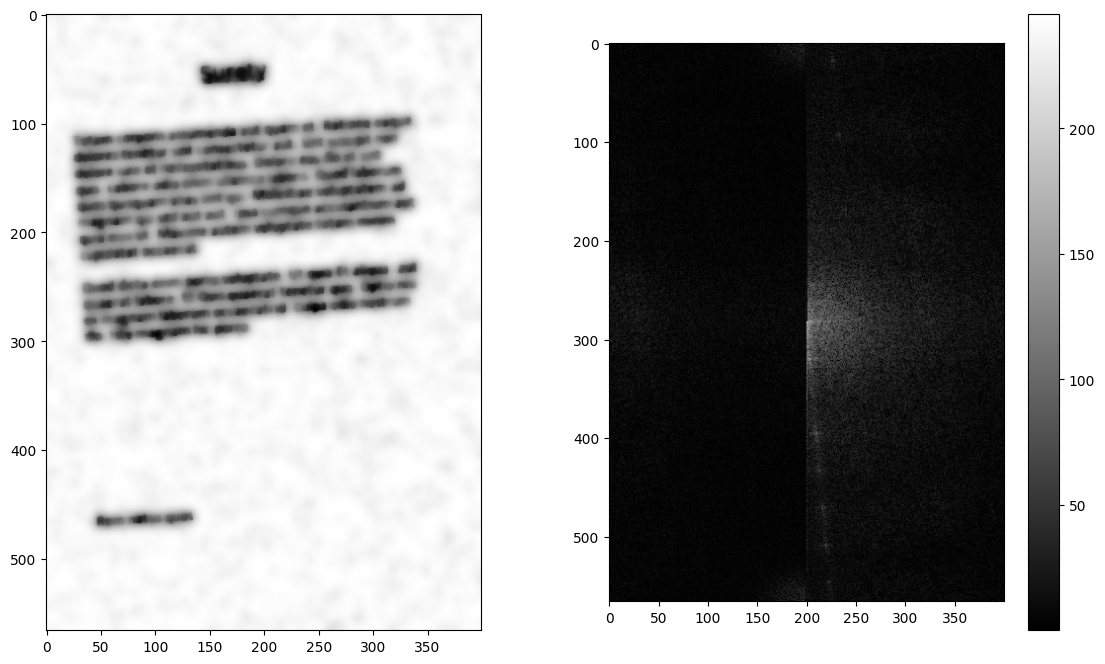

In [8]:
from skimage.restoration import denoise_tv_chambolle

img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)

f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')
#os.system('mkdir -p ./processed')
#cv2.imwrite(path+'/processed/'+names[18], f_img)
plt.colorbar()
plt.show()

In [9]:
fft_images = []
for i in range(N):
    img = cv2.imread(image_paths +'/'+names[i])
    img = img[:,:,0]
    img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
    f = cv2.dft(np.float32(img))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
    f_img = 20 * np.log(f_abs)
    fft_images.append( f_img )
    #cv2.imwrite(path+'/processed/'+names[i], f_img)

<ipython-input-9-36f47a1579e1>:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


In [10]:
# Load and open labels
label_names = [ file for file in os.listdir(label_paths) ]
label_names = sorted(label_names)
M = len(label_names)

print(label_names[:10])


labels = [ np.loadtxt(label_paths+ '/'+label_names[j])
for j in range(M) ]
labels = [ round(float(labels[j])) for j in range(M) ]


# Load first 10 labels
[print(labels[i]) for i in range(10)]
print('Total number of labels %d'%len(labels))

['scan_000.txt', 'scan_001.txt', 'scan_002.txt', 'scan_003.txt', 'scan_004.txt', 'scan_005.txt', 'scan_006.txt', 'scan_007.txt', 'scan_008.txt', 'scan_009.txt']
0
-2
-5
-5
-1
-1
4
0
-5
-2
Total number of labels 500


In [12]:
# Deserialize JSON data lists for training and test sets
with open(root+'/train_list.json') as train_data:
    train = json.load(train_data)

train_size = len(train)
print('Training set size: %d'%train_size)

with open(root+'/test_list.json') as test_data:
    test = json.load(test_data)

test_size = len(test)
print('Test set size: %d'%test_size)

Training set size: 500
Test set size: 100


In [13]:
# Get images into tensor form
image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_images[i])
for i in range(N) ]

# get pixel dimensions of image
img_height = image_arr[0].shape[0]
img_width = image_arr[0].shape[1]

# Training and test image stacks
X = tf.stack(image_arr[:train_size], axis=0, name='train_set')
X_test = tf.stack(image_arr[-test_size:], axis=0, name='test_set')

pixel_count = img_height * img_width

# Reshape to 3D Tensor
X = np.array(X).reshape(train_size, pixel_count)
X_test = np.array(X_test).reshape(test_size, pixel_count)

# Normalise pixel values
X /= 255
X_test /= 255

# Training labels
Y_train_ = np.array(labels).reshape(len(labels))

# Check shape of each tensor
print(X.shape, Y_train_.shape)
print(X_test.shape)

(500, 226400) (500,)
(100, 226400)


In [ ]:
# Show number of unique labels
#classes = np.unique(Y_train_)
#print(classes)
#n_classes = len(np.unique(Y_train_))

# Create classes from unique labels
#Y_train = to_categorical(Y_train_, n_classes)
#print(Y_train.shape)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
(500, 11)


In [14]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y_train_, test_size=0.2, random_state=42)


In [15]:
# Define your regression model
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(pixel_count,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

# Change the output layer for regression
model.add(Dense(1, activation='linear'))  # Linear activation for regression


In [16]:
#Compile the model with a regression loss function (MSE)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])  # Mean squared error (MSE) loss



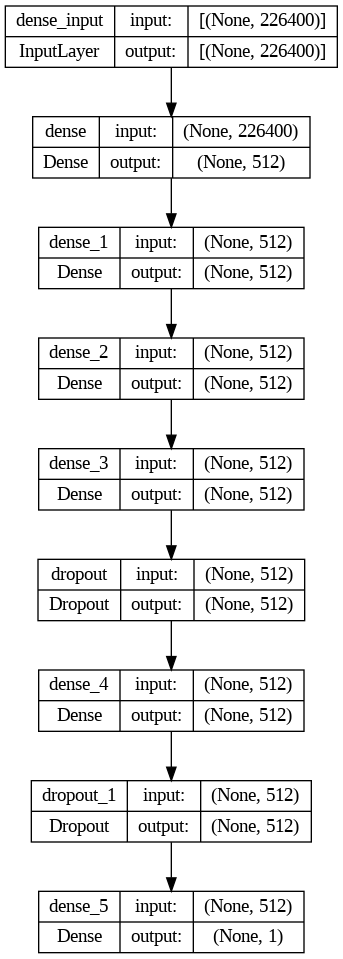

In [18]:
from keras.utils import plot_model

plot_model(model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)
# Train the model and keep track of history
history = model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_val, Y_val))

Epoch 1/50
13/13 - 8s - loss: 60.8431 - mse: 60.8431 - val_loss: 15.0453 - val_mse: 15.0453 - 8s/epoch - 583ms/step
Epoch 2/50
13/13 - 1s - loss: 12.8692 - mse: 12.8692 - val_loss: 9.2380 - val_mse: 9.2380 - 557ms/epoch - 43ms/step
Epoch 3/50
13/13 - 1s - loss: 9.1220 - mse: 9.1220 - val_loss: 9.5360 - val_mse: 9.5360 - 526ms/epoch - 40ms/step
Epoch 4/50
13/13 - 1s - loss: 9.2554 - mse: 9.2554 - val_loss: 8.3591 - val_mse: 8.3591 - 536ms/epoch - 41ms/step
Epoch 5/50
13/13 - 1s - loss: 7.9166 - mse: 7.9166 - val_loss: 6.0628 - val_mse: 6.0628 - 604ms/epoch - 46ms/step
Epoch 6/50
13/13 - 1s - loss: 4.2109 - mse: 4.2109 - val_loss: 1.9637 - val_mse: 1.9637 - 600ms/epoch - 46ms/step
Epoch 7/50
13/13 - 1s - loss: 1.0638 - mse: 1.0638 - val_loss: 1.1854 - val_mse: 1.1854 - 534ms/epoch - 41ms/step
Epoch 8/50
13/13 - 1s - loss: 0.6306 - mse: 0.6306 - val_loss: 0.8097 - val_mse: 0.8097 - 590ms/epoch - 45ms/step
Epoch 9/50
13/13 - 1s - loss: 0.6895 - mse: 0.6895 - val_loss: 1.4273 - val_mse: 1.4

In [20]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

4/4 [==============================] - 0s 21ms/step - loss: 1.0998 - mse: 1.0998
Validation Loss: 1.0998245477676392
Validation Accuracy: 1.0998245477676392


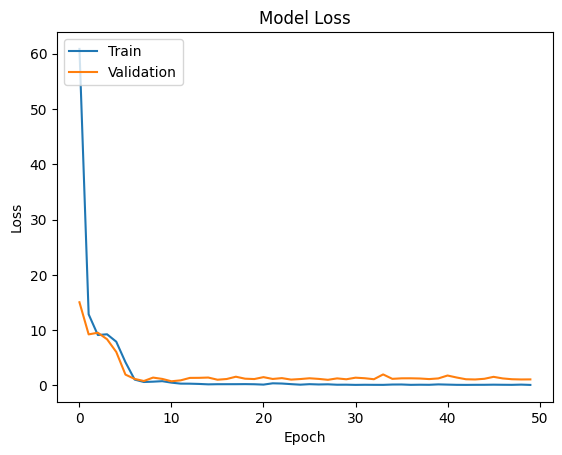

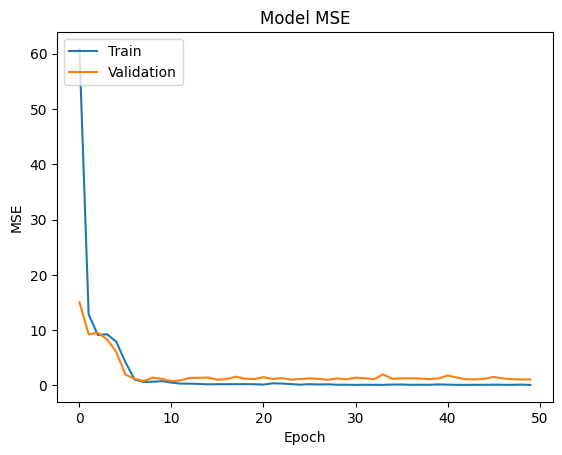

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
predictions = model.predict(X_test)
print(predictions[:10])

4/4 [==============================] - 0s 11ms/step
[[-2.253744  ]
 [-0.92256284]
 [ 0.39809608]
 [-2.8451273 ]
 [-0.55772364]
 [-2.8666866 ]
 [ 2.586185  ]
 [ 0.90112066]
 [ 1.2708312 ]
 [-0.25159165]]


### Save the Model for future use

In [27]:
!pip install pyyaml h5py

model.save(f'{model_path}/{model_name}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Course Descriptor

### Load CSV file from the folder

In [28]:
# Load CSV file data into dataframe
def load_csv(location):
  csv_file_path = os.path.join(location, csv_file_name)

  # Read the CSV file into a DataFrame
  df = pd.read_csv(csv_file_path)

  return df

In [29]:
# Global Section to hold
# 1. Dataset location  - location
# 2. Labels - cd_input_data

location_ref = int(input("Enter 1 for \'input\' folder, 2 for \'tmp_skewed\' folder or 3 for \'tmp_tilt\' folder: "))

match location_ref:
  case 1:
    location = input_path
  case 2:
    location = tmp_skewed_path
  case 3:
    location = tmp_tilt_path

cd_input_data = load_csv(location)

Enter 1 for 'input' folder, 2 for 'tmp_skewed' folder or 3 for 'tmp_tilt' folder: 2


### Load the images and prepare for CNN

In [30]:
fft_cd_images = []
for row in cd_input_data.itertuples():
  img = cv2.imread(f'{location}/{row.FILE_NAME}.png')
  img = cv2.resize(img,(400,566))
  img = img[:,:,0]
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
  f = cv2.dft(np.float32(img))
  fshift = np.fft.fftshift(f)
  f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
  f_img = 20 * np.log(f_abs)
  fft_cd_images.append( f_img )
  #cv2.imwrite(path+'/processed/'+names[i], f_img)

<ipython-input-30-c818ea35a85f>:6: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


In [31]:
# Get images into tensor form
cd_image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_cd_images[i])
for i in range(len(fft_cd_images) )]

# get pixel dimensions of image
img_height = cd_image_arr[0].shape[0]
img_width =  cd_image_arr[0].shape[1]

print(f'image height: {img_height} width: {img_width}')

# Training and test image stacks
X_cd = tf.stack(cd_image_arr, axis=0, name='test_set')

pixel_count = img_height * img_width

# Reshape to 3D Tensor
X_cd = np.array(X_cd).reshape(len(fft_cd_images), pixel_count)

# Normalise pixel values
X_cd /= 255



# Check shape of each tensor
print(X_cd.shape)

image height: 566 width: 400
(91, 226400)


In [32]:
# Load the model
model_pred = load_model(f'{model_path}/{model_name}')

In [33]:
print("Total Params:", model.count_params())
model_pred.summary()

Total Params: 116968449
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               115917312 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (No

In [ ]:
cd_predictions = model.predict(X_cd)
print(cd_predictions)

In [39]:
cd_input_data['PRED'] = cd_predictions


cd_input_data.head(5)

,FILE_NAME,TYPE,VALUE,PRED
0,page_40,S,1.75,0.201507
1,page_41,N,0.00,-0.319210
2,page_42,S,-1.34,-0.830605
3,page_43,N,0.00,-0.360110
4,page_44,S,0.28,-0.207439


<ipython-input-41-7fff932fa13d>:7: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


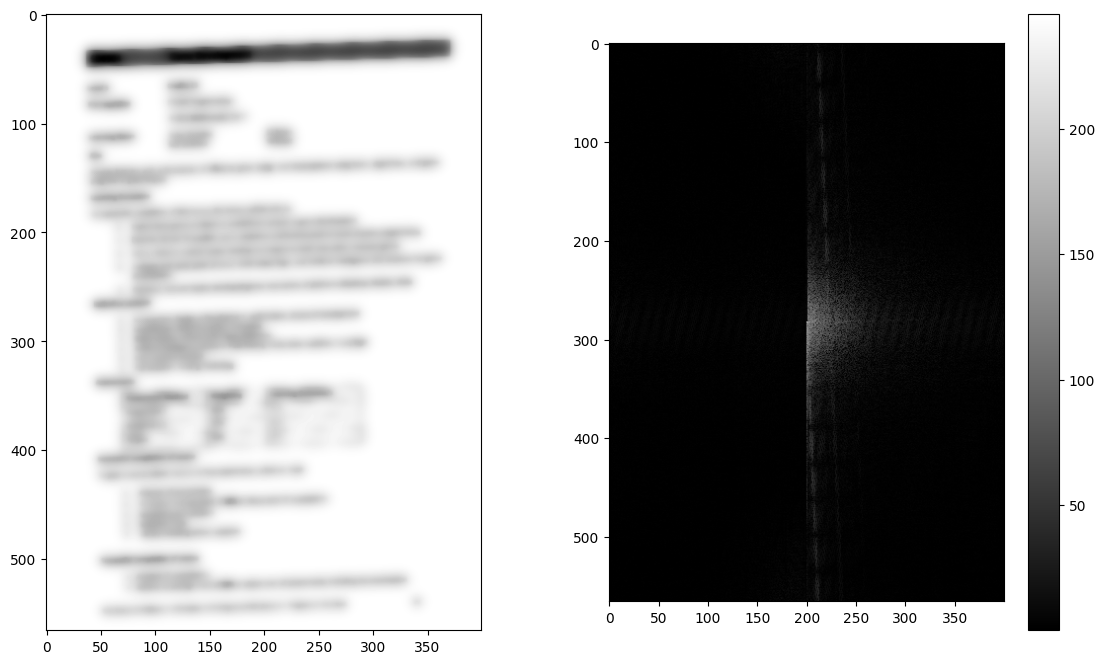

In [41]:
eg_img = location +'/page_80.png'
img = cv2.imread(eg_img)
img = cv2.resize(img,(400,566))
img = img[:,:,0] #zeroth component is the red from RGB channel ordering


img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)

f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')
#os.system('mkdir -p ./processed')
#cv2.imwrite(path+'/processed/'+names[18], f_img)
plt.colorbar()
plt.show()

In [42]:
np.sum(np.square(np.round(np.array(cd_input_data.VALUE),2) - np.round((np.array(cd_input_data.PRED)),2)))/len(cd_input_data)

3.082209892364634

-2.0 -0.9290498
4.86 1.6178733
0.0 -0.37317094


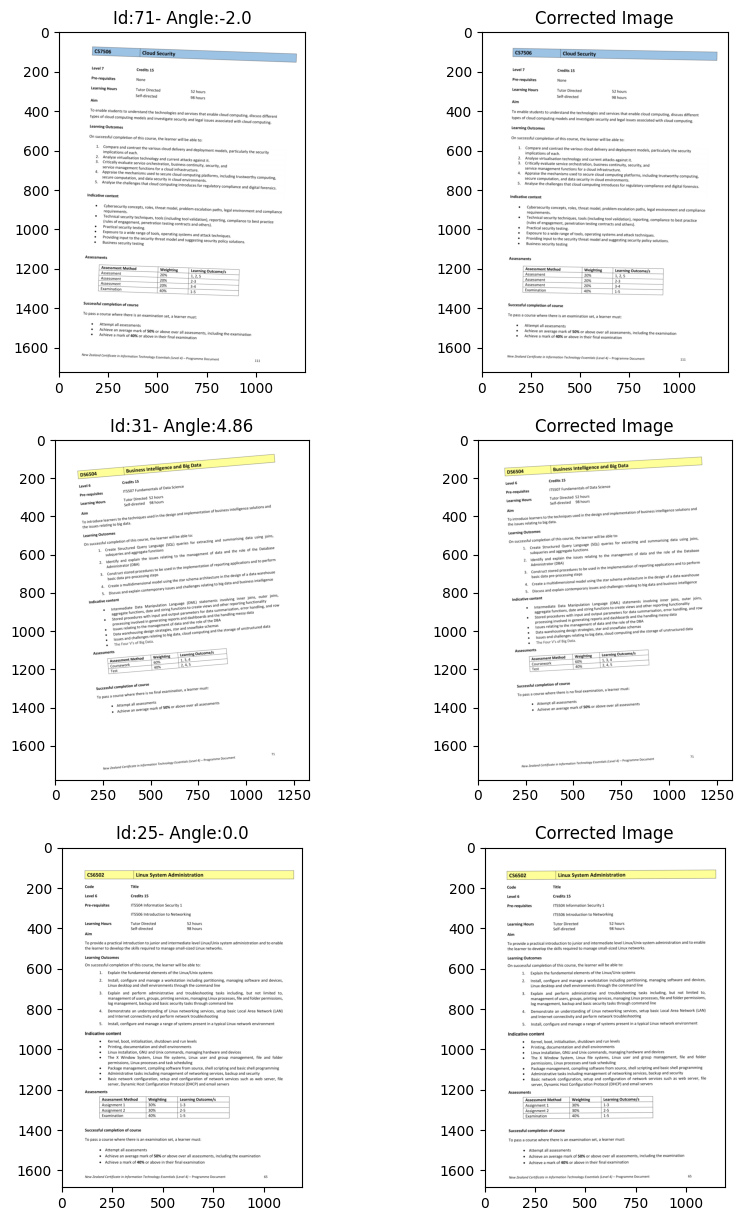

In [45]:
# get random image and label names
def get_random_cd_img(r=[0, 499]):
    id = random.randint(r[0], r[1])
    sample_image_path = os.path.join(location, f'{cd_input_data.iloc[id][0]}.png')
    sample_label = cd_input_data.iloc[id][2]
    pred_label = cd_input_data.iloc[id][3]
    return id, sample_image_path, sample_label, pred_label

# display image
def display_cd_image(path=None, title=None):
    if path is not None:
        img = Image.open(path)

    plt.imshow(img);
    plt.title(title)

def cd_display_image(img, title):
  plt.imshow(img)
  plt.title(title)

# Display random images
plt.figure(figsize=(10,15))
for i in range(1,7,2):
  id, sample_image_path, sample_label, pred_label = get_random_cd_img([0, len(cd_input_data)])
  print(sample_label, pred_label)

  sample_title = "Id:" + str(id) + '- Angle:' + str(sample_label)
  if sample_image_path is not None:
     img = imread(sample_image_path)

  ax = plt.subplot(3, 2, i)
  cd_display_image(img, sample_title)

  # Get the image dimensions
  height, width = img.shape[:2]

  # Calculate the rotation matrix
  rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), -(pred_label), 1)

  # Apply the rotation to the image
  corrected_image = cv2.warpAffine(img, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

  ax = plt.subplot(3, 2, i+1)
  #img_corrected = cd_skewness_correction(img)
  cd_display_image(corrected_image, 'Corrected Image')